# Intelligent Systems Seminar Assignment 1
**Genetic algorith written in python** \
Authors: *Nejc Jezeršek, Žan Oberstar*

### Libraries

In [2]:
import statistics
import math
import random
from matplotlib import pyplot as plt
import numpy as np

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## Population generation

Agent is an arithmetic expression constructed of numbers and symbols specified below.

Each number can be used `max_number_use` times, therefore the expression can contain from `1` to `len(numbers)*max_number_use` numbers.

After each number there is a symbol from `symbols`. The symbol after the last number is ignored, but may be used in future generations like an unexpressed gene in a human genome. That decision was made primarily to make crossover (based on permutations) easier to implement.

In [4]:
numbers = ['10', '25', '100', '5', '3']
symbols = ['+', '-', '*', '/']

max_number_use = 1
min_numbers_in_expresion = 1

target_value = 2512

In [5]:
def generate_agent():
    n_numbers = random.randint(min_numbers_in_expresion, len(numbers)*max_number_use)
    selected_numbers = random.sample(numbers*max_number_use, n_numbers)
    return [(number, random.choice(symbols)) for number in selected_numbers]

def agent_to_expression(agent):
        expression = "".join(n + s for n, s in agent)
        return expression[:-1] # remove last operator
    
def evaluate_agent(agent):
    expression = agent_to_expression(agent)
    if len(expression) == 0: return 0
    else: return eval(expression)

def agent_to_string(agent):
    return f"{agent_to_expression(agent)} = {evaluate_agent(agent):.2f}"

Agent is constructed of tuples of a number and a symbol as seen below:
 - `generate_agent` generates a random agent
 - `agent_to_expression` function joins the tuples together into a string, ignoring the last symbol
 - `evaluate_agent` generates the expression and evaluates it
 - `agent_to_string` creates a string with expression and its value

In [7]:
a = generate_agent()
print("Generate agent   : ", a)
print("Agent expression : ", agent_to_expression(a))
print("Evaluated        : ", evaluate_agent(a))
print("Pretty print     : ", agent_to_string(a))

Generate agent   :  [('10', '+'), ('25', '-'), ('100', '*'), ('5', '*'), ('3', '+')]
Agent expression :  10+25-100*5*3
Evaluated        :  -1465
Pretty print     :  10+25-100*5*3 = -1465.00


Here are some randomly generated agents:

In [6]:
for i in range(20):
    a = generate_agent()
    print(f"{i}. ", agent_to_string(a))

0.  3-10/5 = 1.00
1.  5-3 = 2.00
2.  10-5/100 = 9.95
3.  100+3+10/5-25 = 80.00
4.  10*3+25*5 = 155.00
5.  25 = 25.00
6.  10 = 10.00
7.  25 = 25.00
8.  5*100+25-10/3 = 521.67
9.  3+100-5/25 = 102.80
10.  25-5 = 20.00
11.  25/5 = 5.00
12.  5/10/3+25/100 = 0.42
13.  5 = 5.00
14.  3/5 = 0.60
15.  25*3 = 75.00
16.  100-10/3*25-5 = 11.67
17.  25/5/10*100 = 50.00
18.  10/5+25-3*100 = -273.00
19.  10*5 = 50.00


## Fitness

Fitness is used as a scoring function for the genetic algorithm to determine the best agents to use for reproduction.

We defined some different fitness functions, which will be compared in section _Evaluation_:
 - `fitness_abs` returns the negative of an absolute value of the error
 - `fitness_inverse` returns 1 over an absolute value of the error
 - `fitness_squared` returns negative of the error squared
 - `fitness_log` returns negative of the logarithm of the error

In [8]:
def error(agent):
    return abs(evaluate_agent(agent) - target_value)

def fitness_abs(agent):
    return -error(agent)

def fitness_inverse(agent):
    return 1/(error(agent) + 0.0001) # + 0.0001 to avoid zero devision

def fitness_squared(agent):
    return -(error(agent)**2)

def fitness_log(agent):
    return -math.log2(error(agent)+1)

## Mutation

We defined 7 different types of mutation:
 - `mutation_change_symbol` changes a random symbol
 - `mutation_change_number` changes a random number
 - `mutation_add_element` adds a new element to the agent
 - `mutation_remove_element` removes a random element from the agent
 - `mutation_swap_symbol` swaps two random symbols  
 - `mutation_swap_number` swaps two random numbers
 - `mutation_swap_element` swaps two random elements (i.e. tuples consistion of a number and a symbol ("5", "+"))

We add function `mutation` so that it randomly chooses between all of the mutations listed above

In [9]:
def mutation_change_symbol(agent):
    a = agent.copy()
    i = random.randrange(len(a))
    number, _ = a[i]
    a[i] = (number, random.choice(symbols))
    
    return a

def mutation_change_number(agent):
    a = agent.copy()
    agent_numbers = [number for number, _ in a]
    # choose numbers that can be added without violating `max_number_use`
    candidate_numbers = list(filter(lambda n: agent_numbers.count(n) < max_number_use, numbers))
    if len(candidate_numbers) == 0: return a
    i = random.randrange(len(a))
    _, symbol = a[i]
    a[i] = (random.choice(candidate_numbers), symbol)
    
    return a

def mutation_add_element(agent):
    a = agent.copy()
    agent_numbers = [number for number, _ in a]
    # choose numbers that can be added without violating `max_number_use`
    candidate_numbers = list(filter(lambda n: agent_numbers.count(n) < max_number_use, numbers))
    if len(candidate_numbers) == 0: return a
    a.insert(random.randint(0, len(a)), (random.choice(candidate_numbers), random.choice(symbols)))
    
    return a

def mutation_remove_element(agent):
    a = agent.copy()
    if len(a) <= 1: return a # nothing to remove
    del a[random.randrange(len(a))]
    
    return a

def mutation_swap_symbol(agent):
    a = agent.copy()
    i = random.randrange(len(agent))
    j = random.randrange(len(agent))
    
    a[i], a[j] = (a[i][0], a[j][1]), (a[j][0], a[i][1])
    
    return a

def mutation_swap_number(agent):
    a = agent.copy()
    i = random.randrange(len(agent))
    j = random.randrange(len(agent))
    
    a[i], a[j] = (a[j][0], a[i][1]), (a[i][0], a[j][1])
    
    return a

def mutation_swap_element(agent):
    a = agent.copy()
    i = random.randrange(len(agent))
    j = random.randrange(len(agent))
    
    a[i], a[j] = a[j], a[i]
    
    return a

def mutation(agent):
    mutation_functions = [mutation_change_symbol, mutation_change_number, mutation_add_element, mutation_remove_element, 
                          mutation_swap_number, mutation_swap_symbol, mutation_swap_element]
    return random.choice(mutation_functions)(agent)

Here is an example of all the mutations made on the same agent:

In [15]:
agent = generate_agent()
print("Generated agent : ", agent)
print("Change symbol   : ", mutation_change_symbol(agent))
print("Change number   : ", mutation_change_number(agent))
print("Add element     : ", mutation_add_element(agent))
print("Remove element  : ", mutation_remove_element(agent))
print("Swap symbol     : ", mutation_swap_symbol(agent))
print("Swap number     : ", mutation_swap_number(agent))
print("Swap element    : ", mutation_swap_element(agent))
print("Random mutation : ", mutation(agent))

Generated agent :  [('10', '+'), ('3', '*'), ('25', '+'), ('100', '/')]
Change symbol   :  [('10', '+'), ('3', '*'), ('25', '+'), ('100', '-')]
Change number   :  [('10', '+'), ('3', '*'), ('5', '+'), ('100', '/')]
Add element     :  [('5', '/'), ('10', '+'), ('3', '*'), ('25', '+'), ('100', '/')]
Remove element  :  [('10', '+'), ('3', '*'), ('100', '/')]
Swap symbol     :  [('10', '*'), ('3', '+'), ('25', '+'), ('100', '/')]
Swap number     :  [('10', '+'), ('25', '*'), ('3', '+'), ('100', '/')]
Swap element    :  [('10', '+'), ('3', '*'), ('100', '/'), ('25', '+')]
Random mutation :  [('3', '+'), ('10', '*'), ('25', '+'), ('100', '/')]


## Crossover

Crossover takes 2 parents: `parent1` and `parent2`. \
It then splits `parent1` and `parent2` into 2 parts and takes one part from `parent1` and another from `parent2` and stiches them together to create `child1`. \
It does the same for `child2`, just that it takes the other 2 parts.

### Functions

In [16]:
def agent_subtract(agent1, agent2):
    agent2_numbers = [n for n, _ in agent2]
    res = []
    for number, symbol in agent1:
        if number in agent2_numbers: agent2_numbers.remove(number)
        else: res.append((number, symbol))
    return res

def crossover(parent1, parent2):
    min_len = min(len(parent1), len(parent2))
    selection_start = random.randint(0, min_len)
    selection_end = random.randint(selection_start, min_len)

    child1 = parent1[selection_start:selection_end]
    child2 = parent2[selection_start:selection_end]
    child1.extend(agent_subtract(parent2, child1))
    child2.extend(agent_subtract(parent1, child2))
    
    return (child1, child2)

### Step by step example

We first generate two parents `parent1` and `parent2`:

In [52]:
parent1 = generate_agent()
parent2 = generate_agent()
print("parent1: ", parent1, agent_to_string(parent1))
print("parent2: ", parent2, agent_to_string(parent2))

parent1:  [('25', '-'), ('3', '-'), ('10', '*'), ('100', '+')] 25-3-10*100 = -978.00
parent2:  [('10', '+'), ('3', '*'), ('5', '-'), ('25', '/'), ('100', '*')] 10+3*5-25/100 = 24.75


We then select a section that overlaps both parents and initializes `child1` to a section of `parent1` and `child2` to a section of `parent2`.

In [54]:
min_len = min(len(parent1), len(parent2))
selection_start = random.randint(0, min_len)
selection_end = random.randint(selection_start, min_len)

child1 = parent1[selection_start:selection_end]
child2 = parent2[selection_start:selection_end]

print("child1: ", child1, agent_to_string(child1))
print("child2: ", child2, agent_to_string(child2))

child1:  [('25', '-')] 25 = 25.00
child2:  [('10', '+')] 10 = 10.00


The rest of the elements come from the other parent by removing the numbers that already came from the first parent. \
We do that using the function `agent_subtract`, so that we stay within the bounds of the problem (all of the numbers can only be used once)

In [55]:
parent1_remainder = agent_subtract(parent1, child2)
parent2_remainder = agent_subtract(parent2, child1)

print("parent1_remainder: ", parent1_remainder, agent_to_string(parent1_remainder))
print("parent2_remainder: ", parent2_remainder, agent_to_string(parent2_remainder))

parent1_remainder:  [('25', '-'), ('3', '-'), ('100', '+')] 25-3-100 = -78.00
parent2_remainder:  [('10', '+'), ('3', '*'), ('5', '-'), ('100', '*')] 10+3*5-100 = -75.00


In the end we stich both children together using the `parent_remainder`.

In [56]:
child1.extend(parent2_remainder)
child2.extend(parent1_remainder)

print("child1 result: ", child1, agent_to_string(child1))
print("child2 result: ", child2, agent_to_string(child2))

child1 result:  [('25', '-'), ('10', '+'), ('3', '*'), ('5', '-'), ('100', '*')] 25-10+3*5-100 = -70.00
child2 result:  [('10', '+'), ('25', '-'), ('3', '-'), ('100', '+')] 10+25-3-100 = -68.00


Example of the `crossover` function:

In [57]:
child1, child2 = crossover(parent1, parent2)
print(f"parent1 : {agent_to_string(parent1)}; lenght: {len(parent1)}")
print(f"parent2 : {agent_to_string(parent2)}; length: {len(parent2)}")
print(f"child1  : {agent_to_string(child1)}; length: {len(child1)}")
print(f"child2  : {agent_to_string(child2)}; length: {len(child2)}")

parent1 : 25-3-10*100 = -978.00; lenght: 4
parent2 : 10+3*5-25/100 = 24.75; length: 5
child1  : 100+10+3*5-25 = 100.00; length: 5
child2  : 25/3-10*100 = -991.67; length: 4


## Selection

### Top agents
The first naive approach is to order the agents by their fitness and select the top $n$ agents.

In [18]:
def select_best_agents(population_with_fitness, n_agents):
    return list(sorted(population_with_fitness, key=lambda e: e[1], reverse=True))[:n_agents]

Lets create a 100 agents and select the best 10.

In [25]:
population = [generate_agent() for _ in range(100)]
population_with_fitness = [(a, fitness_log(a)) for a in population]
population_fitness = [f for a, f in population_with_fitness]

best_agents = select_best_agents(population_with_fitness, 10)

for a, f in best_agents:
    print(f"error: {error(a):.3f}, fitness: {f:.3f}, agent: {agent_to_string(a)}, ")

error: 7.000, fitness: -3.000, agent: 100*25+5 = 2505.00, 
error: 22.000, fitness: -4.524, agent: 100*25-10 = 2490.00, 
error: 762.000, fitness: -9.576, agent: 10*25+3*5*100 = 1750.00, 
error: 1238.000, fitness: -10.275, agent: 25*100/10*5*3 = 3750.00, 
error: 1664.667, fitness: -10.702, agent: 10+100*25*5/3 = 4176.67, 
error: 2012.000, fitness: -10.975, agent: 100*5 = 500.00, 
error: 2095.333, fitness: -11.034, agent: 25*5*10/3 = 416.67, 
error: 2182.000, fitness: -11.092, agent: 25+10+3*100-5 = 330.00, 
error: 2182.000, fitness: -11.092, agent: 25+10+100*3-5 = 330.00, 
error: 2259.000, fitness: -11.142, agent: 5*100-25*10+3 = 253.00, 


### Weighted choice
Another approach is to compute wheits based on the fitness value and than make a random weighted choice of $n$ agents.

In [21]:
def get_weights(population_with_fitness, verbose=False):
    k = 1.0 # if k is close to 1 best agents are more favored if k > 1 the difference in weights between different agents gets smaller
    population_fitness = [f for a, f in population_with_fitness]
    min_fitness = min(population_fitness)
    base_fitness = -min_fitness*k
    population_with_weights = [(a, f, ((f+base_fitness)/base_fitness)**2) for a, f in population_with_fitness]
    population_with_weights_ordered = sorted(population_with_weights, key=lambda e: e[2], reverse=True)

    if verbose:
        for a, f, w in population_with_weights_ordered[:10]:
            print(f"fitness: {f:.3f}, weight: {w:.3f}, agent: {agent_to_string(a)}")
            
        weights_ordered = [w for a, f, w in population_with_weights_ordered]
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,1)
        plt.title("Oredered agents (x) and their weights (y)")
        plt.plot(weights_ordered)
        plt.subplot(1,2,2)
        plt.title("Distribution of weights")
        _ = plt.hist(weights_ordered, bins=40)
    
    return [w for a, f, w in population_with_weights]

Lets look at the distribution of the weights with logarithmic fitness function:

fitness: -3.000, weight: 0.599, agent: 100*25+5 = 2505.00
fitness: -4.524, weight: 0.435, agent: 100*25-10 = 2490.00
fitness: -9.576, weight: 0.078, agent: 10*25+3*5*100 = 1750.00
fitness: -10.275, weight: 0.051, agent: 25*100/10*5*3 = 3750.00
fitness: -10.702, weight: 0.038, agent: 10+100*25*5/3 = 4176.67
fitness: -10.975, weight: 0.030, agent: 100*5 = 500.00
fitness: -11.034, weight: 0.029, agent: 25*5*10/3 = 416.67
fitness: -11.092, weight: 0.027, agent: 25+10+3*100-5 = 330.00
fitness: -11.092, weight: 0.027, agent: 25+10+100*3-5 = 330.00
fitness: -11.142, weight: 0.026, agent: 5*100-25*10+3 = 253.00


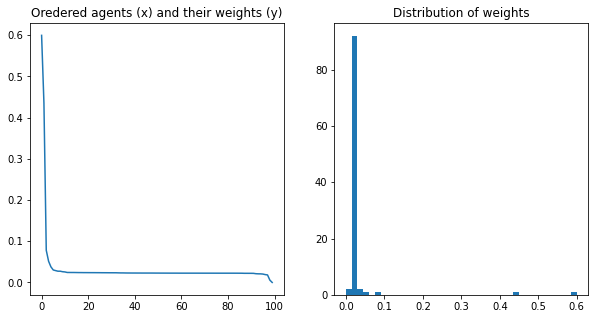

In [26]:
population_with_fitness = [(a, fitness_log(a)) for a in population]
_ = get_weights(population_with_fitness, verbose=True)

We can see that the best few agents get very large weight and the most agents get weights around 0.2 to 0.5 (depends on the population). There are some very bad agents that gat almost 0 weight.

If we use different fitness function (negative absolute error for example), we get differnet distrubution.

fitness: -7.000, weight: 0.999, agent: 100*25+5 = 2505.00
fitness: -22.000, weight: 0.996, agent: 100*25-10 = 2490.00
fitness: -762.000, weight: 0.853, agent: 10*25+3*5*100 = 1750.00
fitness: -1238.000, weight: 0.767, agent: 25*100/10*5*3 = 3750.00
fitness: -1664.667, weight: 0.694, agent: 10+100*25*5/3 = 4176.67
fitness: -2012.000, weight: 0.638, agent: 100*5 = 500.00
fitness: -2095.333, weight: 0.624, agent: 25*5*10/3 = 416.67
fitness: -2182.000, weight: 0.611, agent: 25+10+3*100-5 = 330.00
fitness: -2182.000, weight: 0.611, agent: 25+10+100*3-5 = 330.00
fitness: -2259.000, weight: 0.599, agent: 5*100-25*10+3 = 253.00


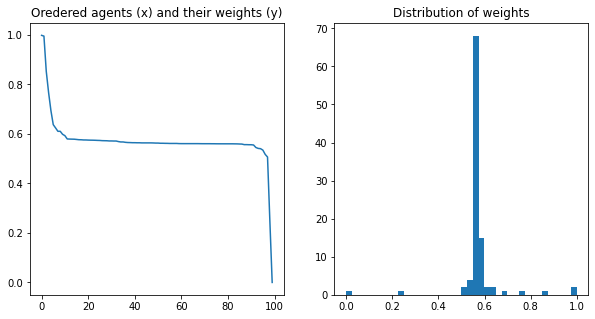

In [27]:
population_with_fitness = [(a, fitness_abs(a)) for a in population]
_ = get_weights(population_with_fitness, verbose=True)

Now we can implement a function that makes a weighted random choice based on before computed wheights:

In [29]:
def select_weighted(population_with_fitness, n_agents):
    weights = get_weights(population_with_fitness)
    return random.choices(population_with_fitness, weights=weights, k=n_agents)

In [30]:
population_with_fitness = [(a, fitness_log(a)) for a in population]
best_agents_weighted = select_weighted(population_with_fitness, 10)

for a, f in best_agents_weighted:
    print(f"error: {error(a):.3f}, fitness: {f:.3f}, agent: {agent_to_string(a)}, ")

error: 2420.000, fitness: -11.241, agent: 100+5-3-10 = 92.00, 
error: 22.000, fitness: -4.524, agent: 100*25-10 = 2490.00, 
error: 762.000, fitness: -9.576, agent: 10*25+3*5*100 = 1750.00, 
error: 22.000, fitness: -4.524, agent: 100*25-10 = 2490.00, 
error: 7.000, fitness: -3.000, agent: 100*25+5 = 2505.00, 
error: 22.000, fitness: -4.524, agent: 100*25-10 = 2490.00, 
error: 2506.000, fitness: -11.292, agent: 10*3/5 = 6.00, 
error: 2482.000, fitness: -11.278, agent: 10*3 = 30.00, 
error: 22.000, fitness: -4.524, agent: 100*25-10 = 2490.00, 
error: 2684.000, fitness: -11.391, agent: 3+25-10*100/5 = -172.00, 


### Best plus random selection

Another approach is to comose the selection of half best agents and other half of randomly chosen agents to avoid elitisem. 

In [31]:
def select_best_plus_random(population_with_fitness, n_agents):
    best_agents = select_best_agents(population_with_fitness, n_agents//2)
    best_agents.extend(random.choices(population_with_fitness, k=(n_agents - n_agents//2)))
    
    return best_agents

## Evolution function


__Parameters:__
 - `population_size`: size of the population to be generated every iteration
 - `fitness_function`: a function that takes an agent and returns its fitness value
 - `selection_function`: a function that takes set of agents with their fitness value and retrns a subset of a few survivers
 - `crossover_function`: a function that takes two agents and returnes two children
 - `mutation_function`: a function that takes an agent and performs a random mutation
 - `mutation_probability`: in mutation process each agent has a probability of mutation
 - `survival_probability`: percentage of agents that will survive and have offspring
 - `max_iterations`: self explanatory
 - `fitness_threshold`: stop when agent with such fitnes value is found
 - `keep_best`: will parents be part of next population or not
 - `verbose`: if true, print metrics for each generation
 - `plot`: if true, plot mean and max fitness in each generation 

In [32]:
def evolve(
    population_size, fitness_function, selection_function, crossover_function, mutation_function, 
    mutation_probability=0.4, survival_probability=0.1, max_iterations=100, fitness_threshold=0, keep_best = False,
    verbose=False, plot=False
):
    population = [generate_agent() for _ in range(population_size)]
    
    min_fitness_log = []
    max_fitness_log = []
    mean_fitness_log = []
    
    string_log = []
    
    iterations = 0
    
    for generation in range(max_iterations):
        iterations += 1
        # evaluate population
        population_with_fitness = [(a, fitness_function(a)) for a in population]
        population_fitness = [f for a, f in population_with_fitness]
        
        # compute metrics
        mean_fitness = statistics.mean(population_fitness)
        max_fitness = max(population_fitness)
        min_fitness = min(population_fitness)
        
        # log metrics
        mean_fitness_log.append(mean_fitness)
        max_fitness_log.append(max_fitness)
        min_fitness_log.append(min_fitness)
        
        # make selection
        best_agents_with_fitness = selection_function(population_with_fitness, math.ceil(population_size*survival_probability))
        best_agents = [a for a, _ in best_agents_with_fitness]
        
        population_with_fitness_sorted = list(sorted(population_with_fitness, key=lambda e: e[1], reverse=True))
        
        # print metrics
        string_log.append(f"Generation {generation}: fitness min: {min_fitness:.2f}, max: {max_fitness:.2f}, mean: {mean_fitness:.2f}; best agent: {agent_to_string(population_with_fitness_sorted[0][0])}")
            
        if max_fitness >= fitness_threshold: break
        
            
        if keep_best:
            population = best_agents.copy()
        else:
            population = []

        # crossover
        for i in range(len(population), population_size, 2):
            parent1, parent2 = random.sample(best_agents, 2)
            child1, child2 = crossover_function(parent1, parent2)
            population.append(child1)
            population.append(child2)
            
        # mutation
        for i, agent in enumerate(population):
            if random.random() < mutation_probability:
                population[i] = mutation_function(agent)
                
    if verbose:
        if len(string_log) > 10:
            for line in string_log[:5]:
                print(line)
            
            print(" ... lines omitted ... ")
            for line in string_log[-5:]:
                print(line)
        else:
            for line in string_log:
                print(line)
            
    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(max_fitness_log, label="max")
        plt.plot(mean_fitness_log, label="mean")
        #plt.plot(min_fitness_log, label="min")
        plt.legend()
        
    return (iterations, (max_fitness_log, mean_fitness_log, min_fitness_log))

## Evaluation

In [34]:
population_size = 100
max_iterations = 300

max_number_use = 1

Generation 0: fitness min: -15.09, max: -3.70, mean: -11.20; best agent: 25*100 = 2500.00
Generation 1: fitness min: -14.46, max: -3.32, mean: -10.66; best agent: 3+25*100 = 2503.00
Generation 2: fitness min: -12.29, max: -1.00, mean: -7.17; best agent: 10+3+25*100 = 2513.00
Generation 3: fitness min: -12.28, max: -3.32, mean: -5.46; best agent: 3+25*100 = 2503.00
Generation 4: fitness min: -12.29, max: -3.32, mean: -6.22; best agent: 3+25*100 = 2503.00
 ... lines omitted ... 
Generation 94: fitness min: -16.15, max: -1.00, mean: -5.04; best agent: 10+3+100*25 = 2513.00
Generation 95: fitness min: -14.46, max: -1.00, mean: -5.54; best agent: 10+3+100*25 = 2513.00
Generation 96: fitness min: -14.46, max: -0.42, mean: -6.23; best agent: 25*100+5/3+10 = 2511.67
Generation 97: fitness min: -14.46, max: -1.00, mean: -5.01; best agent: 100*25+10+3 = 2513.00
Generation 98: fitness min: -14.46, max: -0.00, mean: -5.34; best agent: 5-3+10+100*25 = 2512.00


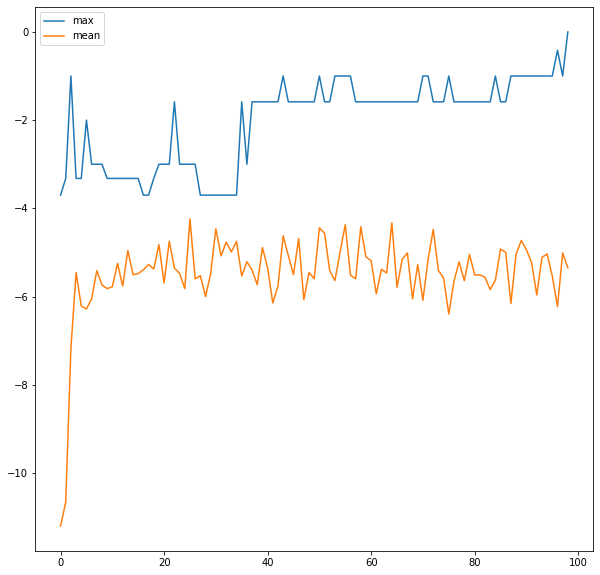

In [35]:
_ = evolve(
    population_size,
    fitness_log,
    select_weighted,
    crossover,
    mutation,
    fitness_threshold=0,
    mutation_probability=0.2, survival_probability=0.2, max_iterations=300,
    verbose=True, keep_best=False, plot=True
)

### Plot iterations histogram

`iterative function` takes no parameters and returns the number of iterations it took to complete

In [36]:
def plot_iterations_histogram(iterative_function, title="", N=200, bins=100, verbose=True):
    iterations_log = []
    for i in range(N):
        iterations_log.append(iterative_function())

    plt.title(title)
    plt.xlabel('Number of iterations')
    plt.ylabel('Number of runs')
    _ = plt.hist(iterations_log, bins=bins, range=(0,300))
    
    if verbose:
        print(f"{title} - mean: {statistics.mean(iterations_log)}, min: {min(iterations_log)}, max: {max(iterations_log)}, stdev: {statistics.stdev(iterations_log)}")
        

### Comparison with random search

Random search works by generating a new random population (the same size as initial population for genetic algorithem) every iteration until the optimal agent is found.

In [37]:
def random_search():
    iterations = 0
    for i in range(max_iterations):
        iterations += 1
        population = [generate_agent() for _ in range(population_size)]
        population_with_fitness = [(a, fitness_abs(a)) for a in population]
        population_fitness = [f for a, f in population_with_fitness]
        if max(population_fitness) == 0: break
        
    return iterations

Random search - mean: 41.84, min: 1, max: 297, stdev: 48.49145808838592
Genetic algorithm - mean: 15.41, min: 1, max: 109, stdev: 16.635069210501978


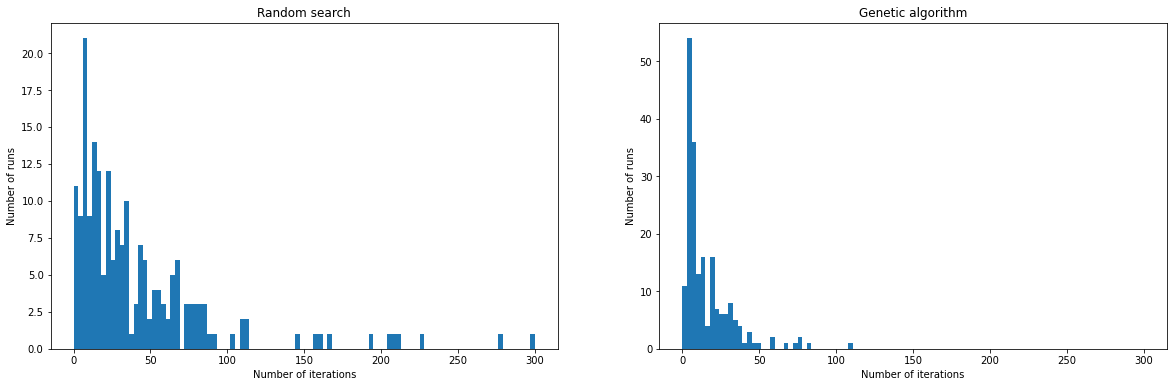

In [38]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plot_iterations_histogram(
    random_search,
    title="Random search"   
)

plt.subplot(1, 2, 2)
plot_iterations_histogram(
    lambda: evolve(
        population_size,
        fitness_log,
        select_best_plus_random,
        crossover,
        mutation,
        mutation_probability=0.2, survival_probability=0.2, max_iterations=300, keep_best=False, fitness_threshold=0
    )[0],
    title="Genetic algorithm"
)

We can see that genetic algorithm, on average, takes less iterations than random search. 

### Different fitness functions

Lets see how does the choice of a fitness function effect performance. We run genetic alghorithm with each fitness function a 200 times and plot a histogram of iterations it took to find the optimal agent. 

abs - mean: 15.38, min: 1, max: 112, stdev: 16.598892013637595
inverse - mean: 15.075, min: 1, max: 92, stdev: 16.478686554236166
squared - mean: 14.17, min: 1, max: 223, stdev: 21.162949989576276
log - mean: 17.185, min: 1, max: 111, stdev: 19.892696445160382


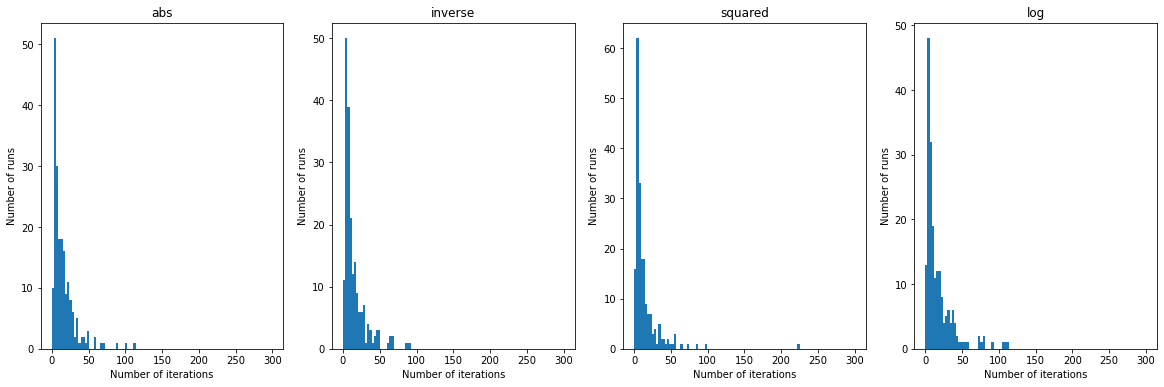

In [39]:
fitness_functions = [(fitness_abs, 0, "abs"), (fitness_inverse, 10000, "inverse"), (fitness_squared, 0, "squared"),  (fitness_log, 0, "log")]

plt.figure(figsize=(20,6))

for j, (fitness_function, fitness_threshold, label) in enumerate(fitness_functions):
    plt.subplot(1, len(fitness_functions), j+1)
    plot_iterations_histogram(
        lambda: evolve(
            population_size,
            fitness_function,
            select_best_plus_random,
            crossover,
            mutation,
            mutation_probability=0.2, survival_probability=0.2, max_iterations=300, keep_best=False, fitness_threshold=fitness_threshold
        )[0],
        title=label
    )

We found out that all fitness functions perform about the same.

### Different selection functions

top agents - mean: 16.23, min: 1, max: 300, stdev: 33.87350248873404
weighted selection - mean: 34.42, min: 1, max: 300, stdev: 51.03416532236766
best plus random - mean: 14.815, min: 1, max: 191, stdev: 19.20612274129708


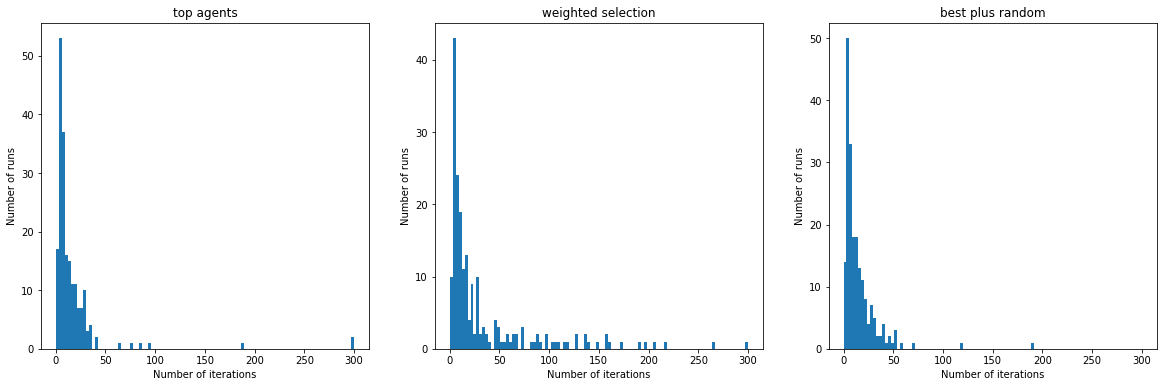

In [46]:
selection_functions = [(select_best_agents, "top agents"), (select_weighted, "weighted selection"), (select_best_plus_random, "best plus random")]

plt.figure(figsize=(20,6))

for j, (selection_function, label) in enumerate(selection_functions):
    plt.subplot(1, len(selection_functions), j+1)
    plot_iterations_histogram(
        lambda: evolve(
            population_size,
            fitness_log,
            selection_function,
            crossover,
            mutation,
            mutation_probability=0.2, survival_probability=0.2, max_iterations=300, keep_best=True, fitness_threshold=0
        )[0],
        title=label
    )

We can see from the results that by selecting just the top few agents sometimes the evolution process does not converge. We think that is because we loose the diversity of the population and get stuck in a local optimum.

By also selecting some worse agents the evolution always converges.

We found that the best selection method for this problem is selecting half of the best agents and half of random agents.

### Keep parents or not

keep parents - mean: 13.855, min: 1, max: 79, stdev: 14.093513066399158
don't keep parents - mean: 16.1, min: 1, max: 159, stdev: 21.96456717204499


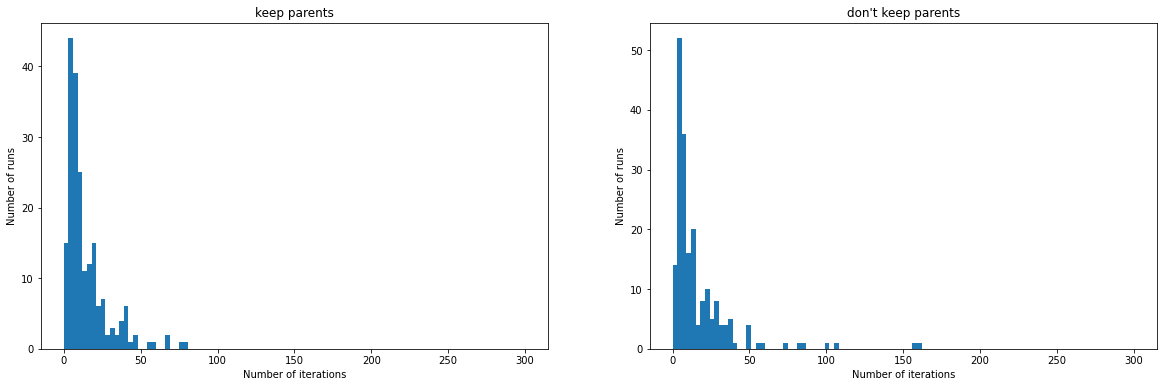

In [42]:
selection_functions = [(True, "keep parents"), (False, "don't keep parents")]

plt.figure(figsize=(20,6))

for j, (keep, label) in enumerate(selection_functions):
    plt.subplot(1, len(selection_functions), j+1)
    plot_iterations_histogram(
        lambda: evolve(
            population_size,
            fitness_log,
            select_best_plus_random,
            crossover,
            mutation,
            mutation_probability=0.2, survival_probability=0.2, max_iterations=300, keep_best=keep, fitness_threshold=0
        )[0],
        title=label
    )

Keeping parents appears to converge a bit faster.

## Bonus task: minimize expression length

In [47]:
max_number_use = 5
min_numbers_in_expresion = 1

For this task we have to define a new fitness function that also takes into account the expression length.

In [48]:
def fitness_length(agent):
    return fitness_inverse(agent) + 3/(len(agent)+5)

Generation 0: fitness min: 0.10, max: 0.50, mean: 0.21; best agent: 100 = 100.00
Generation 1: fitness min: 0.12, max: 0.50, mean: 0.35; best agent: 100 = 100.00
Generation 2: fitness min: 0.13, max: 0.50, mean: 0.42; best agent: 100 = 100.00
Generation 3: fitness min: 0.13, max: 0.50, mean: 0.46; best agent: 100 = 100.00
Generation 4: fitness min: 0.18, max: 0.50, mean: 0.47; best agent: 100 = 100.00
 ... lines omitted ... 
Generation 22: fitness min: 0.30, max: 1.33, mean: 0.67; best agent: 10+3+25*100 = 2513.00
Generation 23: fitness min: 0.27, max: 1.33, mean: 0.71; best agent: 10+3+25*100 = 2513.00
Generation 24: fitness min: 0.30, max: 1.33, mean: 0.67; best agent: 10+3+25*100 = 2513.00
Generation 25: fitness min: 0.25, max: 1.33, mean: 0.71; best agent: 3+10+25*100 = 2513.00
Generation 26: fitness min: 0.30, max: 10000.30, mean: 100.72; best agent: 5-3+10+100*25 = 2512.00


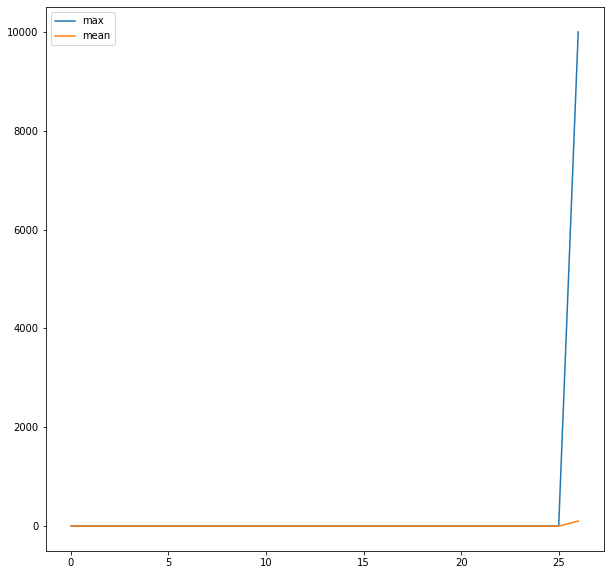

In [49]:
_ = evolve(
    population_size,
    fitness_length,
    select_best_plus_random,
    crossover,
    mutation,
    fitness_threshold=10000.00,
    mutation_probability=0.5, survival_probability=0.2, max_iterations=300,
    verbose=True, keep_best=True, plot=True
)

In [51]:
def fitness_length_2(agent):
    return fitness_abs(agent) - len(agent)*2

Generation 0: fitness min: -1687501777.00, max: -33.58, mean: -17032506.61; best agent: 3-10/5-25/3/5+5/100*25-5+25*100+10/5*10 = 2515.58
Generation 1: fitness min: -29995176.15, max: -33.58, mean: -606836.21; best agent: 3-10/5-25/3/5+5/100*25-5+25*100+10/5*10 = 2515.58
Generation 2: fitness min: -123210.98, max: -33.58, mean: -3373.95; best agent: 3-10/5-25/3/5+5/100*25-5+25*100+10/5*10 = 2515.58
Generation 3: fitness min: -252341.00, max: -30.02, mean: -5014.97; best agent: 3/5+5/100*25-5+10/3/25-5+25*100+10/5*10 = 2511.98
Generation 4: fitness min: -122507.58, max: -30.02, mean: -2641.06; best agent: 3/5+5/100*25-5+10/3/25-5+25*100+10/5*10 = 2511.98
 ... lines omitted ... 
Generation 295: fitness min: -22506.00, max: -8.00, mean: -1565.32; best agent: 10+25*100 = 2510.00
Generation 296: fitness min: -247506.00, max: -8.00, mean: -7072.95; best agent: 25*100+10 = 2510.00
Generation 297: fitness min: -22494.00, max: -8.00, mean: -1462.92; best agent: 25*100+10 = 2510.00
Generation 29

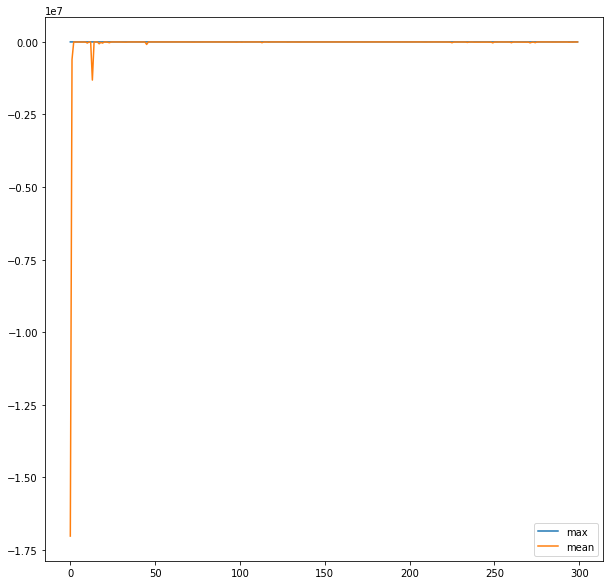

In [53]:
_ = evolve(
    population_size,
    fitness_length_2,
    select_best_plus_random,
    crossover,
    mutation,
    fitness_threshold=0,
    mutation_probability=0.4, survival_probability=0.2, max_iterations=300,
    verbose=True, keep_best=False, plot=True
)

Depending on the fitness function we get either shorter but slightly incorrect expression or long and correct one.